# ***Trabalho de simulação 2*** 
Yago Alves da Costa - 115212477
<br> Pedro Pinto Moya - 113083474<br> Victor Lisboa - 113102692
<br> Gabriel Silva Pereira - 115192431


## Simuladores e funções auxiliares

In [ ]:
import random
import math
import numpy as np
import pandas as pd
from math import isclose
import matplotlib.pyplot as plt
import typing

In [ ]:
# Intervalo de confiança da t-student
def tstudent_ci(mean, variance, samples):
  # Verifica se a media e variancia tem valores nulos (ou bem proximos disso)
  if isclose(mean, 0, abs_tol=1e-9) and isclose(variance, 0, abs_tol=1e-9):
    return 0.0, 0.0, 0.0
  # desvio padrao (raiz quadrada da variancia)
  std_dev = math.sqrt(variance)
  # metade do intervalo
  term = 1.960 * (std_dev/math.sqrt(samples))
  # limite superior do intervalo
  upper_limit = mean + term
  # limite inferior do intervalo
  lower_limit = mean - term
  # precisao do intervalo de confiança (metade do intervalo / centro do intervalo)
  precision = term / mean
  return lower_limit, upper_limit, precision

In [ ]:
def simulator_1(cClients, maxClientToServe, v_lambda, v_mi):
  round = 0
  simulationTime = 0
  clientsInQueue = cClients
  clientsServed = 0
  accumlatedClients = 0
  startingBusyTime =  0 if cClients > 0 else None
  totalCicles = 1
  busyTime = 0
  B_c = 0
  U_c = 0
  firstRound = True

  while clientsServed < maxClientToServe:
    arrivalTime = random.expovariate(v_lambda)
    departureTime = random.expovariate(v_mi)
    if clientsInQueue == 0:
      if arrivalTime < departureTime:
        simulationTime += arrivalTime
        startingBusyTime = simulationTime
        clientsInQueue += 1
      else:
        simulationTime += departureTime
    else:
      if arrivalTime < departureTime:
        simulationTime += arrivalTime
        clientsInQueue += 1
      else:
        simulationTime += departureTime
        clientsServed += 1
        clientsInQueue -= 1
        if clientsInQueue == 1 and firstRound == True:
          U_c = simulationTime - startingBusyTime
        if clientsInQueue == 0:
          busyTime += simulationTime - startingBusyTime
          if firstRound == True:
            B_c = busyTime
            firstRound = False
          totalCicles += 1
          startingBusyTime = None
    
    accumlatedClients += clientsInQueue
    round += 1

  if startingBusyTime is not None:
    busyTime += simulationTime - startingBusyTime
    if firstRound == True:
      B_c = busyTime
      firstRound = False
    totalCicles += 1

  # given Little' Law L = v_lambda*W
  L = accumlatedClients/ round  # round
  # W is the average time in the system
  W = L/v_lambda
  B = busyTime/totalCicles
  return W, L, B, B_c, U_c

In [ ]:
def scenario(simulator, v_clients, v_lambda, v_mi, maxClients, samples):
  simTimeRounds = []
  simClientsRounds = []
  simBusyRounds = []
  simB_cRounds = []
  simU_cRounds = []
  metricRounds = [simTimeRounds, simClientsRounds, simBusyRounds, simB_cRounds, simU_cRounds]
  for i in range(samples):
    resSim = simulator(v_clients, maxClients, v_lambda, v_mi)
    simTimeRounds.append(resSim[0])
    simClientsRounds.append(resSim[1])
    simBusyRounds.append(resSim[2])
    simB_cRounds.append(resSim[3])
    simU_cRounds.append(resSim[4])
  # [ mean variance lower_limit upper_limit precision ]
  ret = []
  for metric in metricRounds:
    stats = []
    stats.append(np.mean(metric))
    stats.append(np.var(metric))
    stats = stats + list(tstudent_ci(stats[0], stats[1], samples))
    ret.append(stats)
  return ret

def modList(a, v):
  a[0] = v
  return a

# ***1.2)***

In [ ]:
simulators = [
    simulator_1,
]

lam = 1
mu = 2
samples = 10**4
tableData = [] 
for simulator in simulators:
  simRes = ['Estatística']
  simRes.append(lam)
  simRes.append(mu)
  simRes.append(100)
  simRes.append(samples)
  simRes.append(0)
  scenarioRes = scenario(simulator, 0, lam, mu, 100, samples)[:-2]
  tableData.append(modList(simRes.copy(), 'Média') + [f'{row[0]:.4f}' for row in scenarioRes])
  tableData.append(modList(simRes.copy(), 'Variância') + [f'{row[1]:.4f}' for row in scenarioRes])
  tableData.append(modList(simRes.copy(), 'Intervalo de Confiança') + [str(f'{row[2]:.4f}')+' - '+str(f'{row[3]:.4f}') for row in scenarioRes])

df = pd.DataFrame(tableData, columns=['Estatística', '\u03BB', '\u03BC', 'clientes',
  'amostras', 'Clientes no começo - C', 'Tempo - W', 'Clientes - L', 'Período Ocupado - B'])

print('Soluções analíticas')
print('=========================')
L = lam / (mu - lam)
print(f'L = {L}')
W = 1 / (mu - lam)
print(f'W = {W}')
rho = lam / mu
print('\u03C1 = ', rho)
eb = (1 / mu)/(1-rho)
print('E(B) = ', eb)
print('=========================')
print('Simulação')
df.head(50)

Soluções analíticas
L = 1.0
W = 1.0
ρ =  0.5
E(B) =  1.0
Simulação


,Estatística,λ,μ,clientes,amostras,Clientes no começo - C,Tempo - W,Clientes - L,Período Ocupado - B
0,Média,1,2,100,10000,0,1.0078,1.0078,1.0030
1,Variância,1,2,100,10000,0,0.1209,0.1209,0.0723
2,Intervalo de Confiança,1,2,100,10000,0,1.0010 - 1.0146,1.0010 - 1.0146,0.9977 - 1.0082


# ***2.1)***

In [ ]:
simulators = [
    simulator_1,
]

lam = 1
mu = 2
samples = 10**4
meanData = []
varianceData = []
confidenceData = []
v_E_B_c = []
v_Sim_E_B_c = []
v_IC_l = []
v_IC_u = []
v_c = []
for simulator in simulators:
  for c in range(2, 11):
    simRes = []
    simRes.append(lam)
    simRes.append(mu)
    simRes.append(100)
    simRes.append(samples)
    simRes.append(c)
    scenarioRes = scenario(simulator, c, lam, mu, 100, samples)[:-1]
    meanData.append(simRes + [f'{row[0]:.4f}' for row in scenarioRes])
    varianceData.append(simRes + [f'{row[1]:.4f}' for row in scenarioRes])
    confidenceData.append(simRes + [str(f'{row[2]:.4f}')+' - '+str(f'{row[3]:.4f}') for row in scenarioRes])
    v_c.append(c)
    v_E_B_c.append(c*(1 / mu)/(1-rho))
    v_Sim_E_B_c.append([row[0] for row in scenarioRes][3])
    v_IC_l.append([row[2] for row in scenarioRes][3])
    v_IC_u.append([row[3] for row in scenarioRes][3])

dfMean = pd.DataFrame(meanData, columns=['\u03BB', '\u03BC', 'clientes', 'amostras', 'Clientes no começo - C', 
  'Tempo - W', 'Clientes - L', 'Período Ocupado - B', 'B começando com C clientes - B_c'])
dfVariance = pd.DataFrame(varianceData, columns=['\u03BB', '\u03BC', 'clientes', 'amostras', 'Clientes no começo - C', 
  'Tempo - W', 'Clientes - L', 'Período Ocupado - B', 'B começando com C clientes - B_c'])
dfConfidence = pd.DataFrame(confidenceData, columns=['\u03BB', '\u03BC', 'clientes', 'amostras', 'Clientes no começo - C', 
  'Tempo - W', 'Clientes - L', 'Período Ocupado - B', 'B começando com C clientes - B_c'])

print('Soluções analíticas')
print('=========================')
L = lam / (mu - lam)
print(f'L = {L}')
W = 1 / (mu - lam)
print(f'W = {W}')
rho = lam / mu
print('\u03C1 = ', rho)
eb = (1 / mu)/(1-rho)
print('E(B) = ', eb)
print('E(B_c) = ' + str(E_B_c))
print('=========================')

Soluções analíticas
L = 1.0
W = 1.0
ρ =  0.5
E(B) =  1.0
E(B_c) = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]


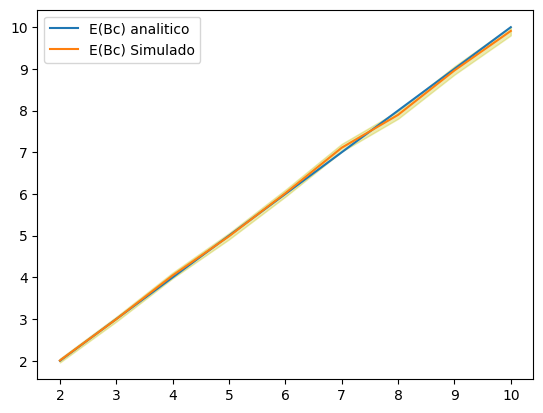

In [ ]:
plt.plot(v_c, v_E_B_c, label = 'E(Bc) analitico')
plt.plot(v_c, v_Sim_E_B_c, label = 'E(Bc) Simulado')
plt.fill_between(v_c, v_IC_l, v_IC_u, color='y', alpha=.3)
plt.legend()
plt.show()

In [ ]:
dfMean.head(20)

,λ,μ,clientes,amostras,Clientes no começo - C,Tempo - W,Clientes - L,Período Ocupado - B,B começando com C clientes - B_c
0,1,2,100,10000,2,1.0221,1.0221,1.0192,2.0067
1,1,2,100,10000,3,1.0478,1.0478,1.0374,2.9736
2,1,2,100,10000,4,1.0980,1.0980,1.0708,4.0816
3,1,2,100,10000,5,1.1464,1.1464,1.0911,5.0708
4,1,2,100,10000,6,1.2094,1.2094,1.1158,6.0421
5,1,2,100,10000,7,1.2860,1.2860,1.1466,6.9941
6,1,2,100,10000,8,1.3673,1.3673,1.1738,8.0742
7,1,2,100,10000,9,1.4670,1.4670,1.2028,8.9678
8,1,2,100,10000,10,1.5788,1.5788,1.2329,9.9923


In [ ]:
dfVariance.head(20)

,λ,μ,clientes,amostras,Clientes no começo - C,Tempo - W,Clientes - L,Período Ocupado - B,B começando com C clientes - B_c
0,1,2,100,10000,2,0.1270,0.1270,0.0783,6.2176
1,1,2,100,10000,3,0.1252,0.1252,0.0801,8.7689
2,1,2,100,10000,4,0.1481,0.1481,0.0926,12.6684
3,1,2,100,10000,5,0.1579,0.1579,0.0964,15.3865
4,1,2,100,10000,6,0.1804,0.1804,0.1047,17.3868
5,1,2,100,10000,7,0.2154,0.2154,0.1196,20.4566
6,1,2,100,10000,8,0.2585,0.2585,0.1495,24.9965
7,1,2,100,10000,9,0.3007,0.3007,0.1683,26.2652
8,1,2,100,10000,10,0.3533,0.3533,0.1639,29.8239


In [ ]:
dfConfidence.head(20)

,λ,μ,clientes,amostras,Clientes no começo - C,Tempo - W,Clientes - L,Período Ocupado - B,B começando com C clientes - B_c
0,1,2,100,10000,2,1.0151 - 1.0291,1.0151 - 1.0291,1.0138 - 1.0247,1.9578 - 2.0556
1,1,2,100,10000,3,1.0408 - 1.0547,1.0408 - 1.0547,1.0318 - 1.0429,2.9156 - 3.0317
2,1,2,100,10000,4,1.0905 - 1.1055,1.0905 - 1.1055,1.0648 - 1.0767,4.0118 - 4.1513
3,1,2,100,10000,5,1.1386 - 1.1542,1.1386 - 1.1542,1.0851 - 1.0972,4.9939 - 5.1477
4,1,2,100,10000,6,1.2011 - 1.2177,1.2011 - 1.2177,1.1094 - 1.1221,5.9603 - 6.1238
5,1,2,100,10000,7,1.2769 - 1.2951,1.2769 - 1.2951,1.1398 - 1.1534,6.9055 - 7.0828
6,1,2,100,10000,8,1.3573 - 1.3773,1.3573 - 1.3773,1.1662 - 1.1814,7.9762 - 8.1721
7,1,2,100,10000,9,1.4562 - 1.4777,1.4562 - 1.4777,1.1948 - 1.2109,8.8673 - 9.0682
8,1,2,100,10000,10,1.5672 - 1.5905,1.5672 - 1.5905,1.2249 - 1.2408,9.8852 - 10.0993


# ***2.2)***

In [ ]:
simulators = [
    simulator_1,
]

lam = 1
mu = 2
samples = 10**4
meanData = []
varianceData = []
confidenceData = []
E_B_c = []
E_U_c = []
v_E_U_c = []
v_Sim_E_U_c = []
v_IC_l = []
v_IC_u = []
v_c = []
for simulator in simulators:
  for c in range(1, 11):
    E_B_c.append(c*(1 / mu)/(1-rho))
    E_U_c.append((c-1)*(mu - lam))
    simRes = []
    simRes.append(lam)
    simRes.append(mu)
    simRes.append(100)
    simRes.append(samples)
    simRes.append(c)
    scenarioRes = scenario(simulator, c, lam, mu, 100, samples)
    meanData.append(simRes + [f'{row[0]:.4f}' for row in scenarioRes])
    varianceData.append(simRes + [f'{row[1]:.4f}' for row in scenarioRes])
    confidenceData.append(simRes + [str(f'{row[2]:.4f}')+' - '+str(f'{row[3]:.4f}') for row in scenarioRes])
    v_c.append(c)
    v_E_U_c.append(c*(1 / mu)/(1-rho))
    v_Sim_E_U_c.append([row[0] for row in scenarioRes][4])
    v_IC_l.append([row[2] for row in scenarioRes][4])
    v_IC_u.append([row[3] for row in scenarioRes][4])

dfMean = pd.DataFrame(meanData, columns=['\u03BB', '\u03BC', 'clientes', 'amostras', 'Clientes no começo - C', 
  'Tempo - W', 'Clientes - L', 'Período Ocupado - B', 'B com C clientes - B_c', 'Fila com 1 cliente a partir e de C clientes - U_c'])
dfVariance = pd.DataFrame(varianceData, columns=['\u03BB', '\u03BC', 'clientes', 'amostras', 'Clientes no começo - C', 
  'Tempo - W', 'Clientes - L', 'Período Ocupado - B', 'B com C clientes - B_c', 'Fila com 1 cliente a partir e de C clientes - U_c'])
dfConfidence = pd.DataFrame(confidenceData, columns=['\u03BB', '\u03BC', 'clientes', 'amostras', 'Clientes no começo - C', 
  'Tempo - W', 'Clientes - L', 'Período Ocupado - B', 'B com C clientes - B_c', 'Fila com 1 cliente a partir e de C clientes - U_c'])

print('Soluções analíticas')
print('=========================')
L = lam / (mu - lam)
print(f'L = {L}')
W = 1 / (mu - lam)
print(f'W = {W}')
rho = lam / mu
print('\u03C1 = ', rho)
eb = (1 / mu)/(1-rho)
print('E(B) = ', eb)
print('E(B_c) = ' + str(E_B_c))
print('E(U_c) = ' + str(E_U_c))
print('=========================')

Soluções analíticas
L = 1.0
W = 1.0
ρ =  0.5
E(B) =  1.0
E(B_c) = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
E(U_c) = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


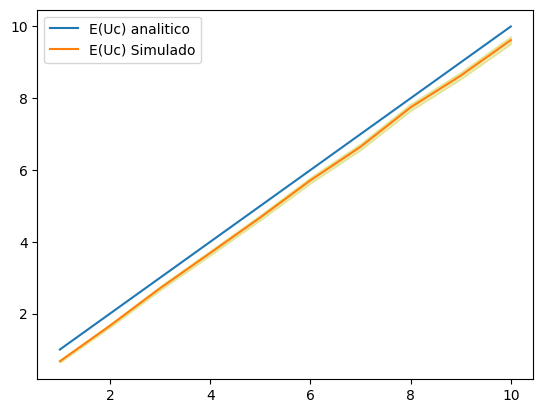

In [ ]:
plt.plot(v_c, v_E_U_c, label = 'E(Uc) analitico')
plt.plot(v_c, v_Sim_E_U_c, label = 'E(Uc) Simulado')
plt.fill_between(v_c, v_IC_l, v_IC_u, color='y', alpha=.3)
plt.legend()
plt.show()

In [ ]:
dfMean.head(20)

,λ,μ,clientes,amostras,Clientes no começo - C,Tempo - W,Clientes - L,Período Ocupado - B,B com C clientes - B_c,Fila com 1 cliente a partir e de C clientes - U_c
0,1,2,100,10000,1,1.0082,1.0082,1.0004,1.0300,0.6985
1,1,2,100,10000,2,1.0198,1.0198,1.0176,2.0250,1.6942
2,1,2,100,10000,3,1.0544,1.0544,1.0461,3.0398,2.7020
3,1,2,100,10000,4,1.0905,1.0905,1.0634,3.9382,3.6045
4,1,2,100,10000,5,1.1522,1.1522,1.0962,5.1079,4.7782
5,1,2,100,10000,6,1.2043,1.2043,1.1170,5.9926,5.6659
6,1,2,100,10000,7,1.2762,1.2762,1.1400,6.9523,6.6250
7,1,2,100,10000,8,1.3682,1.3682,1.1716,7.9679,7.6376
8,1,2,100,10000,9,1.4730,1.4730,1.1996,9.0947,8.7584
9,1,2,100,10000,10,1.5838,1.5838,1.2357,10.0315,9.6981


In [ ]:
dfVariance.head(20)

,λ,μ,clientes,amostras,Clientes no começo - C,Tempo - W,Clientes - L,Período Ocupado - B,B com C clientes - B_c,Fila com 1 cliente a partir e de C clientes - U_c
0,1,2,100,10000,1,0.1170,0.1170,0.0713,3.0801,2.9588
1,1,2,100,10000,2,0.1156,0.1156,0.0730,6.2146,6.1089
2,1,2,100,10000,3,0.1296,0.1296,0.0830,8.9627,8.8830
3,1,2,100,10000,4,0.1406,0.1406,0.0876,11.5321,11.3918
4,1,2,100,10000,5,0.1631,0.1631,0.1024,15.7371,15.6430
5,1,2,100,10000,6,0.1846,0.1846,0.1055,18.4454,18.3127
6,1,2,100,10000,7,0.2103,0.2103,0.1132,20.5720,20.4446
7,1,2,100,10000,8,0.2568,0.2568,0.1281,24.2245,24.0459
8,1,2,100,10000,9,0.3170,0.3170,0.1408,28.2511,28.1680
9,1,2,100,10000,10,0.3944,0.3944,0.1639,31.7915,31.6503


In [ ]:
dfConfidence.head(20)

,λ,μ,clientes,amostras,Clientes no começo - C,Tempo - W,Clientes - L,Período Ocupado - B,B com C clientes - B_c,Fila com 1 cliente a partir e de C clientes - U_c
0,1,2,100,10000,1,1.0015 - 1.0149,1.0015 - 1.0149,0.9951 - 1.0056,0.9956 - 1.0644,0.6648 - 0.7323
1,1,2,100,10000,2,1.0131 - 1.0265,1.0131 - 1.0265,1.0123 - 1.0229,1.9761 - 2.0739,1.6457 - 1.7426
2,1,2,100,10000,3,1.0473 - 1.0614,1.0473 - 1.0614,1.0404 - 1.0517,2.9811 - 3.0985,2.6436 - 2.7604
3,1,2,100,10000,4,1.0831 - 1.0978,1.0831 - 1.0978,1.0576 - 1.0692,3.8716 - 4.0047,3.5384 - 3.6707
4,1,2,100,10000,5,1.1443 - 1.1601,1.1443 - 1.1601,1.0899 - 1.1024,5.0301 - 5.1857,4.7007 - 4.8557
5,1,2,100,10000,6,1.1959 - 1.2127,1.1959 - 1.2127,1.1106 - 1.1234,5.9084 - 6.0768,5.5820 - 5.7497
6,1,2,100,10000,7,1.2672 - 1.2852,1.2672 - 1.2852,1.1334 - 1.1466,6.8634 - 7.0412,6.5364 - 6.7136
7,1,2,100,10000,8,1.3583 - 1.3782,1.3583 - 1.3782,1.1646 - 1.1786,7.8715 - 8.0644,7.5415 - 7.7337
8,1,2,100,10000,9,1.4620 - 1.4841,1.4620 - 1.4841,1.1923 - 1.2070,8.9905 - 9.1988,8.6544 - 8.8625
9,1,2,100,10000,10,1.5715 - 1.5961,1.5715 - 1.5961,1.2278 - 1.2437,9.9210 - 10.1421,9.5879 - 9.8084
